## Import Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import tensorflow as tf
from tqdm import tqdm

Load the data from csv file which includes the name of the the image file, image dimensions, class label of image and bounding box coordinates of the image. The data is laoded as the pandas Data frame.

Total number of rows: 11996

Some rows of the data can be seen below.

In [39]:
data = pd.read_csv('train/_annotations.csv')

rows = data.shape[0]
print(rows)
data.head()

11996


,filename,width,height,class,xmin,ymin,xmax,ymax
0,I__00003_JPG_jpg.rf.850389f58f00a52473d75089d2...,1700,1308,Hog,315,659,669,907
1,I__00003_JPG_jpg.rf.850389f58f00a52473d75089d2...,1700,1308,Hog,1344,733,1442,897
2,f474ac9b-30b2-4fa9-af6b-ed3c4c7fc821_jpg.rf.84...,490,380,Raccoon,238,0,367,93
3,5221bdc9-0c77-4635-aed8-b44475ee41d9_jpg.rf.84...,644,500,Rabbit,263,189,339,236
4,4cafc755-b879-48de-b13c-a86393e32556_jpg.rf.84...,626,486,Deer,388,50,626,426


Total of 5 classes can be seen in the data

In [41]:
num_classes = len(data['class'].unique())
print("Number of classes:", num_classes)

Number of classes: 5


## Data loading and preprocessing

Data fucntion loads the csv file and makes the list of image paths, bounding boxe coordinates, class labels and using the computer vision library opencv, the images aer read and stored in a list. It takes only the folder name considering the folder is placed in the same directory as the notebook.

In [42]:
def Data(image_folder):
    image_paths = []
    images = []
    bounding_boxes = []
    class_labels = []

    data = pd.read_csv(image_folder + '/_annotations.csv')

    for index, row in tqdm(data.iterrows()):
        image_path = os.path.join(image_folder, row['filename'])
        image = cv.imread(image_path) # type: ignore

        x_min, y_min, x_max, y_max = row['xmin'], row['ymin'], row['xmax'], row['ymax']

        class_label = row['class']

        image_paths.append(image_path)
        images.append(image)
        bounding_boxes.append((x_min, y_min, x_max, y_max))
        class_labels.append(class_label)

    return image_paths, images, bounding_boxes, class_labels

In [ ]:
image_paths, images, bounding_boxes, class_labels = Data('train')

Now the images and their data is loaded and saved in seperate lists

Some of the images with their bounding boxes can be seen in the plots below. 

Note that the images are not of the same size, so the images have to be resized to a standard size before inputing to the neural network.

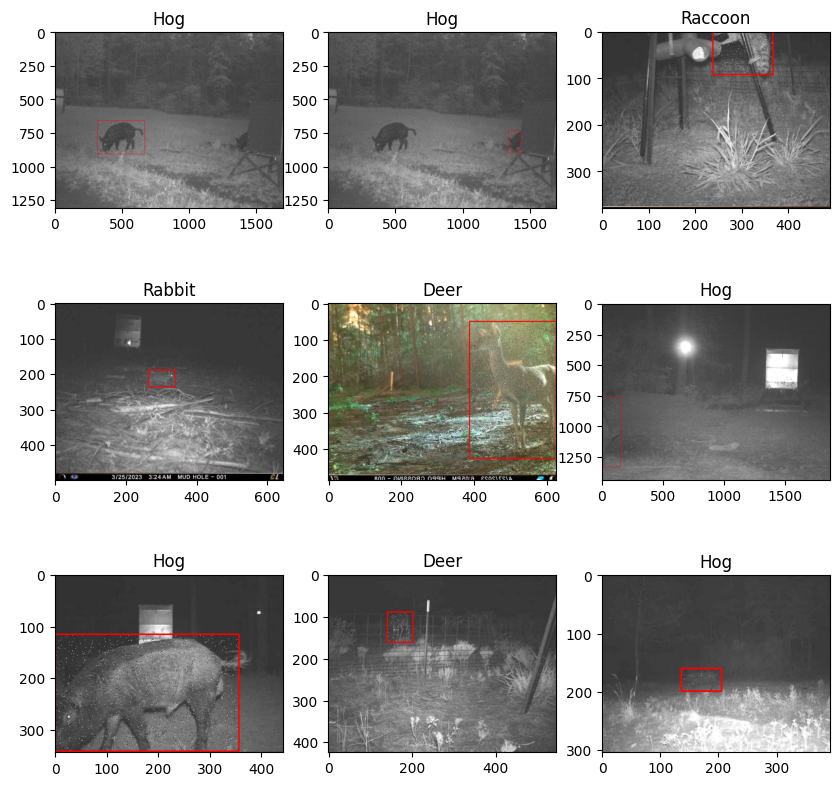

In [44]:
plt.figure(figsize=(10,10))

for i in range(9):
    im = images[i].copy()
    xmin, ymin, xmax, ymax = bounding_boxes[i]
    plt.subplot(3,3,i+1)
    cv.rectangle(im, (xmin, ymin), (xmax, ymax), (255,0,0), 2) # type: ignore
    plt.imshow(im)
    plt.title(class_labels[i])


The resize function takes in the images and their bounding boxes and resize them to a standard size (in this case (128,128.3)). Those resized images and boxes are saved in seperate lists 

As images are resized, the bounding boxes also have to be resized.

The formula used is 
<br>resized_x_min = x_min * (target_width/image_width)</br>
                          <br>resized_y_min = y_min * (target_height/image_height)</br>
                          <br>resized_x_max = x_max * (target_width/image_width)</br>
                          <br>resized_y_max = x_max * (target_height/image_height)</br>

In [45]:
def resize(images, bounding_boxes, target_size):
    resized_images = []
    resized_bbox = []
    
    for i in tqdm(range(len(images))):
        im = images[i]
        xmin, ymin, xmax, ymax = bounding_boxes[i]

        y_ = im.shape[0]
        x_ = im.shape[1]
        x_scale = target_size[0]/x_
        y_scale = target_size[1]/y_

        resized_image = cv.resize(im, target_size) # type: ignore

        resized_xmin = int(np.round(xmin*x_scale))
        resized_ymin = int(np.round(ymin*y_scale))
        resized_xmax = int(np.round(xmax*x_scale))
        resized_ymax = int(np.round(ymax*y_scale))

        resized_box = [resized_xmin, resized_ymin, resized_xmax, resized_ymax]

        resized_images.append(resized_image)
        resized_bbox.append(resized_box)

    return resized_images, resized_bbox
        

In [ ]:
resized_images, resized_bbox = resize(images, bounding_boxes, target_size=(128,128))

A preview of resized images can be seen below with original and resized images and bounding boxes

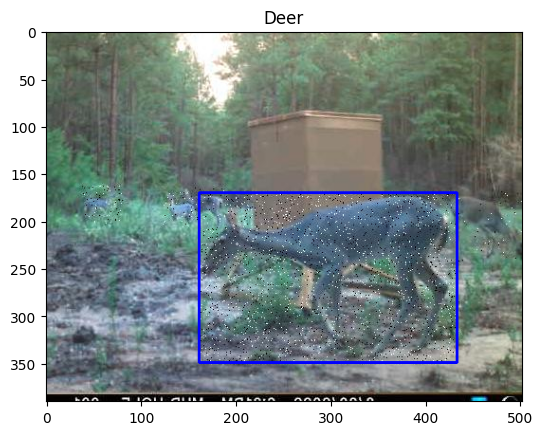

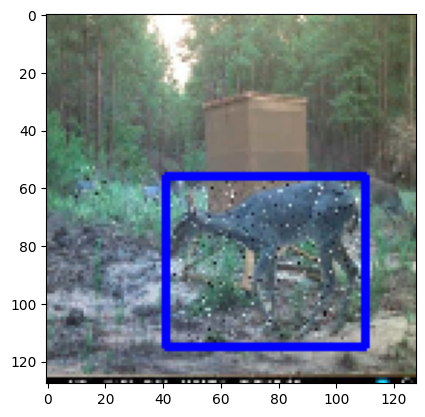

In [47]:
im = images[946].copy()
res = resized_images[946].copy()
box = bounding_boxes[946]
res_box = resized_bbox[946]
cv.rectangle(im, (box[0], box[1]), (box[2], box[3]), (0,0,255), 2) # type: ignore
cv.rectangle(res, (res_box[0], res_box[1]), (res_box[2], res_box[3]), (0,0,255), 2)
plt.imshow(im)
plt.title(class_labels[946])
plt.show()
plt.imshow(res)
plt.show()


## Normalize

Training images list is converted to arrays and normalized by dividing the images by 255 which converts the numbers between 0 and 1.
<br>A new array, train_object, is created for imdicating object presence in the image. Since all images have objects in them, the array will be of size equal to images array and all emmebrs will be 1 indicating presence of the object</br>

In [48]:
resized_images = np.array(resized_images)
resized_bbox = np.array(resized_bbox)

train_images = resized_images
train_bbox = resized_bbox
train_object = np.ones(len(train_images))

In [49]:
train_images = train_images/255

Data augmentation is the process of modifying, or “augmenting” a dataset with additional data. This can help improve the performance of the model.

Image Augmentation can be applied to increase the dataset. But due to low computation power, the augmentation process is not performed in this project. ImageDataGenerator from tensorflow library can be used for this process. The arguments include image rotation, width, height shifts, zoom etc. 


Total Augmented Images=Number of Original Images×Batch Size×Number of Epochs×(1 + Augmentation Factor)

In [22]:
# import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)

train_generator = datagen.flow(train_images, (train_bbox), batch_size=32)

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img

for i in range(5):  # Adjust the number of batches you want to visualize
    batch_x, batch_y = train_generator.next()
    labels = batch_y[0]

    # Visualize the first image in the batch
    # img = array_to_img(batch_x[0])
    img = batch_x[0]
    cv.rectangle(img, (labels[0], labels[1]), (labels[2], labels[3]), (0,0,255), 2)
    plt.imshow(img)
    plt.title(f'Label: {batch_y[0]}')
    plt.show()

## CNN Model

In [ ]:
import tensorflow as tf

def CNN(input_shape):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape, name='CONV3-64-1'),
                tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='CONV3-64-2'),
                tf.keras.layers.MaxPool2D((2,2), name='POOL2-1'),
                tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name='CONV3-128-1'),
                tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name='CONV3-128-2'),
                tf.keras.layers.MaxPool2D((2,2), name='POOL2-2'),
                tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='CONV3-256-1'),
                tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='CONV3-256-2'),
                tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='CONV3-256-3'),
                tf.keras.layers.MaxPool2D((2,2), name='POOL2-3'),
                tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='CONV3-512-1'),
                tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='CONV3-512-2'),
                tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='CONV3-512-3'),
                tf.keras.layers.MaxPool2D((2,2), name='POOL2-4'),
                tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same', name='CONV3-512-4'),
                tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same', name='CONV3-512-5'),
                tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same', name='CONV3-512-6'),
                tf.keras.layers.MaxPool2D((2,2), name='POOL2-5'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, activation='relu', name='FC-1'),
                tf.keras.layers.Dense(1, activation='sigmoid', name='object_presence'),
                tf.keras.layers.Dense(512, activation='relu', name='FC-2'),
                tf.keras.layers.Dense(4, activation='linear', name='Bounding_Box')
        ])
        return model

model = CNN((128,128,3))
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Callbacks were added to the training process:
* on_epoch_end was used to stop the training process when reached equal to or more than 85% accuracy. 
* model_checkpoint_callback saves the training weights after each epoch.

In [55]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    if(logs.get('accuracy') > 0.85):

      print("\nAccuracy is greater than 85%, so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [56]:
checkpoint_filepath = 'model_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',  # You can use other metrics like 'val_accuracy' based on your task
    mode='min',
    save_best_only=True
)

## Validation Data

Validation data was read, resized and used in the training process to calculate validation accuracy and validation loss. 

In [57]:
val_image_paths, val_images, val_BoundingBoxes, val_classLabels = Data('valid')

1011it [00:21, 46.68it/s]


Text(0.5, 1.0, 'Deer')

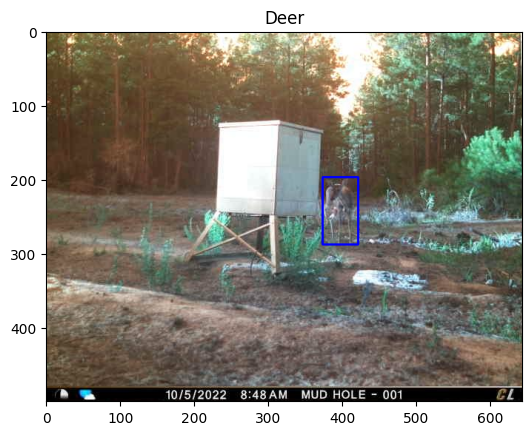

In [58]:
im = val_images[0]
cv.rectangle(im, ((val_BoundingBoxes[0])[0], (val_BoundingBoxes[0])[1]), ((val_BoundingBoxes[0])[2], (val_BoundingBoxes[0])[3]), (0,0,255), 2)
plt.imshow(im)
plt.title(val_classLabels[0])

In [ ]:
val_images, val_bbox = resize(val_images, val_BoundingBoxes, target_size=(128,128))

In [60]:
val_images = np.array(val_images)
val_bbox = np.array(val_bbox)
val_object = np.ones(len(val_images))

# val_images = val_images/255

Two output layer model was used, different loss functions were used for both layers. <br>{Object_presence: binary_crossentropy, bounding_box: mean_squared_error}</br>

The model was compiled with **adam** optimizer and **Mean Squared error** loss function. 

In [69]:
model.compile(optimizer='adam', loss={'object_presence': 'binary_crossentropy', 'bounding_box': 'mean_squared_error'},
              metrics=['accuracy'])

early stopping can be used for stopping the nmodel training early if accuracy does not change for some epochs in this case patience=3

In [70]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',  # monitor validation loss
    patience=3,           # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # restore the model weights from the epoch with the best value of the monitored quantity
)

<br>Model was trained on 10 epochs and batch sizes of 32.</br>
Below error shows the start of the training process on previous model (a part of VGG-16), the training time was too big.

In [ ]:
history = model.fit(train_images, [train_object, train_bbox],
                    {'object_presence': train_object, 'Bounding_Box': train_bbox},
                    epochs=10,
                    validation_data=(val_images, {'object_presence': val_object, 'Bounding_Box': val_bbox}),
                    validation_data = (val_images, [val_object, val_bbox]),
                    callbacks=[callbacks, model_checkpoint_callback])


Below code cell is used to save the final model architecture and final model weights

In [72]:
# Save the final model weights separately
final_weights_filepath = 'final_model_weights.h5'
model.save_weights(final_weights_filepath)

# Optionally, save the entire model architecture and weights in one file
full_model_filepath = 'full_model.h5'
model.save(full_model_filepath)

The plots show the Accuracy and Loss graphs with each epoch.

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.title('Accuracy')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Loss')

plt.show()